In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

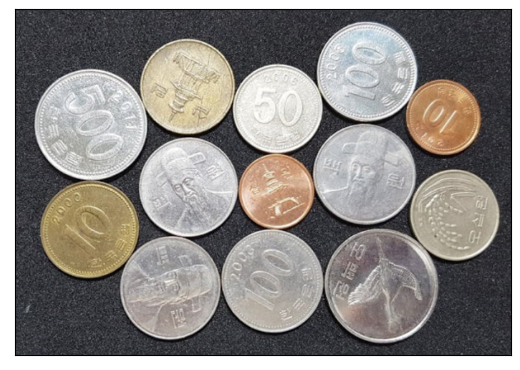

In [50]:
# 이미지 읽기
img = cv2.imread('./img/coins_connected.jpg')
plt.imshow(img[:,:,::-1])
plt.xticks([])
plt.yticks([])
plt.show()

In [61]:
try:
    rows, cols = img.shape[:2]
    cv2.imshow('original', img)

    # 동전 표면을 흐릿하게 피라미드 평균 시프트 적용
    mean = cv2.pyrMeanShiftFiltering(img, 20, 50)
#     1. 평균 시프트 적용 후
#     cv2.imshow('mean', mean)
    # 바이너리 이미지 변환
    gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     2. 바이너리 변환
#     cv2.imshow('thresh', thresh)
    # 거리 변환
    dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 3)
    # 거리값을 0~255로 변환
    dst = (dst/(dst.max() - dst.min()) * 255).astype(np.uint8)
#     3. 거리변환
#     cv2.imshow('dst', dst)

    # 거리 변환 결과에서 로컬 최대값 구하기
    ## 팽창 연산 적용(동전 크기 정도의 구조화 요소 필요)
    localMax = cv2.dilate(dst, np.ones((50, 50), np.uint8))
    ## 로컬 최대값을 저장할 배열 생성
    lm = np.zeros((rows, cols), np.uint8)
    ## 팽창 연산 적용 전 이미지와 같은 픽셀이 로컬 최대값이므로 255로 설정
    lm[(localMax==dst) & (dst != 0)] = 255
#     4. 로컬 최대값(중심 찾기)
#     cv2.imshow('localMax', lm)

    # 로컬 최대값으로 색 채우기
    ## 로컬 최대값이 있는 좌표 구하기
    seeds = np.where(lm == 255)
    seed = np.stack((seeds[1], seeds[0]), axis=-1)
    ## 색 채우기 위한 채우기 마스크 생성
    fill_mask = np.zeros((rows+2, cols+2), np.uint8)
    for x, y in seed:
        ## 로컬 최대값을 시드로 해서 평균 시프트 영상에 색 채우기
        ret = cv2.floodFill(mean, fill_mask, (x, y), (255, 255, 255), (10, 10, 10), (10, 10, 10))
#     5. 평균 시프트 이미지에 로컬 최대값으로 색 채우기
#     cv2.imshow('floodFill', mean)

    # 색 채우기를 적용한 영상에 다시 거리 변환 적용
    gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    dst = ((dst/(dst.max() - dst.min())) * 255).astype(np.uint8)
#     6. 색채우기 한 영상에 다시 거리변환
#     cv2.imshow('dst2', dst)

    # 거리 변환 결과값의 절반 이상을 차지한 영역은 확실한 전경으로 설정
    ret, sure_fg = cv2.threshold(dst, 0.5*dst.max(), 255, 0)
#     7. 거리변환 결과의 0.5 이상 영역을 확실한 전경으로 설정
#     cv2.imshow('sure_fg', sure_fg)

    # 거리 변환 결과를 반전해서 확실한 배경 찾기
    _, bg_th = cv2.threshold(dst, 0.3*dst.max(), 255, cv2.THRESH_BINARY_INV)
    bg_dst = cv2.distanceTransform(bg_th, cv2.DIST_L2, 5)
    bg_dst = ((bg_dst/(bg_dst.max() - bg_dst.min())) * 255).astype(np.uint8)
    ret, sure_bg = cv2.threshold(bg_dst, 0.3*bg_dst.max(), 255, cv2.THRESH_BINARY)
#     8. 거리변환 결과를 반전해서 확실한 배경 찾기
#     cv2.imshow('sure_gb', sure_bg)

    # 불확실한 영역 설정 : 확실한 배경을 반전해서 확실한 전경 빼기
    ret, inv_sure_bg = cv2.threshold(sure_bg, 127, 255, cv2.THRESH_BINARY_INV)
    unknown = cv2.subtract(inv_sure_bg, sure_fg)
#     9. 확실한 배경에서 확실한 전경을 빼기 - 불확실한 영역 찾기
#     cv2.imshow('unknown', unknown)

    # 연결된 요소 레이블링
    _, markers = cv2.connectedComponents(sure_fg)

    # 레이블링을 1씩 증가시키고 레이블을 알 수 없는 영역을 0번 레이블로 설정
    markers = markers + 1
    markers[unknown == 255] = 0
    print('before Wartershed:', np.unique(markers))
    colors = []
    marker_show = np.zeros_like(img)
    for mid in np.unique(markers):    # 선택한 마커 아이디 개수만큼 반복
        color = [int(j) for j in np.random.randint(0, 255, 3)]
        colors.append((mid, color))
        marker_show[markers==mid] = color
        coords = np.where(markers==mid)
        x, y = coords[1][0], coords[0][0]
        cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))
#     10. 영역마다 레이블 설정, 불확실한 영역은 0
#     cv2.imshow('before', marker_show)

    # 레이블이 완성된 마커로 워터셰드 적용
    markers = cv2.watershed(img, markers)
    print('after Watershed:', np.unique(markers))

    for mid, color in colors:    # 선택한 마커 아이디 개수만큼 반복
        marker_show[markers==mid] = color
        coords = np.where(markers==mid)
        if coords[0].size <= 0:
            continue
        x, y = coords[1][0], coords[0][0]
        cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))

    marker_show[markers==-1] = (0, 255, 0)
#     11. 워터셰드 마커
#     cv2.imshow('watershed marker', marker_show)

    img[markers==-1] = (0, 255, 0)
#     12. 워터셰드 적용
#     cv2.imshow('watershed', img)

    # 동전 추출을 위한 마스킹 생성
    mask = np.zeros((rows, cols), np.uint8)
    # 배경 마스크 생성
    mask[markers != 1] = 255
    # 배경 지우기
    nobg = cv2.bitwise_and(img, img, mask=mask)
    # 동전만 있는 라벨 생성(배경(1), 경계(-1) 없는)
    coin_label = [l for l in np.unique(markers) if (l != 1 and l != -1)]
    coins_list = []
    # 동전 라벨을 순회하면서 동전 영역만 추출
    for i, label in enumerate(coin_label):
        mask[:, :] = 0
        # 해당 동전 추출 마스크 생성
        mask[markers == label] = 255
        # 동전 영역만 마스크 추출
        coins = cv2.bitwise_and(img, img, mask=mask)
        # 동전 하나만 있는 곳에서 최외곽 컨투어 추출
        contour, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]

        # 동전을 감싸는 사각형 좌표
        x, y, w, h = cv2.boundingRect(contour[0])

        # 동전 영역만 추출해서 출력
        coin = coins[y:y+h, x:x+w]
#         print(f'coin{i+1} shape:', coin.shape, type(coin))
        coin = cv2.resize(coin, (150, 150), None)
        print(f'after resize coin{i+1} shape:', coin.shape, type(coin))
        coins_list.append(coin)
#         cv2.imshow(f'coin{i+1}', coin)
        cv2.imwrite(f'./img/coin_test/coin{i+1}.jpg', coin)
    
    # 결과 출력
    merged_1 = np.hstack((coins_list[:5]))
    merged_2 = np.hstack((coins_list[5:10]))
    tmp1 = np.zeros((150, 150, 3), dtype = np.uint8)
    tmp2 = np.zeros((150, 150, 3), dtype = np.uint8)
    merged_3 = np.hstack((coins_list[10], coins_list[11], coins_list[12], tmp1, tmp2))
    merged = np.vstack((merged_1, merged_2, merged_3))
    cv2.imshow('coins', merged)
    cv2.waitKey()
    cv2.destroyAllWindows()
except Exception as e:
    print('에러가 발생했습니다 : \n', e)
    cv2.destroyAllWindows()

before Wartershed: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
after Watershed: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
after resize coin1 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin2 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin3 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin4 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin5 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin6 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin7 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin8 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin9 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin10 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin11 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin12 shape: (150, 150, 3) <class 'numpy.ndarray'>
after resize coin13 shape: (150, 150, 3) <class 'numpy.ndarray'>
